### Telecom Churn Prediction (Academic Study)

This notebook extends an existing telecom churn prediction system as an academic study and experimentation exercise.

#### Imports & Setup
Key libraries for preprocessing, modeling, evaluation, clustering, and persistence.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

import joblib

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)
RANDOM_STATE = 42

#### Feature Engineering Function
Adds tenure, recency, stability, and ratio-based fields while dropping identifiers to reduce leakage.

In [2]:
# Feature Engineering Function
def add_features(df, refrence_date="2025-08-27"):
    """
    Add engineered features for churn prediction.
    df : pandas.DataFrame, Input dataset containing telecom churn features.
    refrence_date : str, default="2025-08-27" - Reference date used to calculate tenure and recency-based features.
    Returns: DataFrame with new features and unnecessary columns dropped.
    """
    # Convert reference date to pandas timestamp
    refrence_date = pd.Timestamp(refrence_date)

    # Work on a copy to avoid modifying the original dataframe
    df = df.copy()

    # Customer tenure in days since signup
    df["tenure_days"] = (refrence_date - df["signup_date"]).dt.days

    # Days since last activity (recency feature)
    df["days_since_last_activity"] = (refrence_date - df["last_activity_ts"]).dt.days

    # New customer indicator (tenure < 90 days)
    df["is_new_customer"] = (df["tenure_days"] < 90).astype(int)

    # Support tickets per dropped call (add +1 to denominator to avoid division by zero)
    df["tickets_per_dropped"] = df["num_support_tickets_last_3m"] / (df["num_dropped_calls_last_30d"] + 1)

    # Drop identifiers and raw timestamps (avoid data leakage and high-cardinality features)
    df = df.drop(columns=["customer_id", "signup_date", "last_activity_ts"])

    return df

#### Load and Inspect Data

In [3]:
# Load data
df = pd.read_csv("telecom_churn_full.csv", parse_dates=["signup_date","last_activity_ts"])


In [4]:
# 1) Basic info
print("Shape:", df.shape)
print("Data Types:")
print(df.dtypes)


Shape: (2000, 23)
Data Types:
customer_id                             int64
signup_date                    datetime64[ns]
last_activity_ts               datetime64[ns]
plan_type                              object
monthly_data_gb                       float64
avg_call_minutes                      float64
num_support_tickets_last_3m             int64
num_dropped_calls_last_30d              int64
payment_method                         object
auto_pay                                int64
last_bill_amount                      float64
is_promo                                int64
city                                   object
region                                 object
device_type                            object
contract_type                          object
data_overage_gb_last_3m               float64
intl_call_minutes_last_3m             float64
complaints_last_3m                      int64
net_promoter_score                    float64
age                                     int64
gend

In [5]:
# Check missing values
print("Missing Values per Column:")
print(df.isna().sum())


Missing Values per Column:
customer_id                      0
signup_date                      0
last_activity_ts                 0
plan_type                        0
monthly_data_gb                126
avg_call_minutes               139
num_support_tickets_last_3m      0
num_dropped_calls_last_30d       0
payment_method                  74
auto_pay                         0
last_bill_amount                 0
is_promo                         0
city                             0
region                           0
device_type                      0
contract_type                    0
data_overage_gb_last_3m          0
intl_call_minutes_last_3m        0
complaints_last_3m               0
net_promoter_score             164
age                              0
gender                           0
churn                            0
dtype: int64


In [6]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [7]:
# Target balance (churn distribution)
print("Churn distribution:")
print(df['churn'].value_counts(normalize=True))


Churn distribution:
churn
0    0.7615
1    0.2385
Name: proportion, dtype: float64


In [8]:
# Quick numeric summary
print("Summary Statistics:")
print(df.describe())


Summary Statistics:
         customer_id                    signup_date  \
count    2000.000000                           2000   
mean   100999.500000  2023-10-05 02:56:23.100541184   
min    100000.000000  2022-01-01 15:53:54.496285952   
25%    100499.750000  2022-11-08 16:16:34.250086400   
50%    100999.500000  2023-09-26 09:45:13.389315328   
75%    101499.250000  2024-08-30 01:39:12.560637952   
max    101999.000000  2025-06-30 06:16:57.626050560   
std       577.494589                            NaN   

                    last_activity_ts  monthly_data_gb  avg_call_minutes  \
count                           2000      1874.000000       1861.000000   
mean   2025-06-15 09:02:09.635416576        18.133725        256.748148   
min    2025-05-01 01:25:05.543649792         1.226404         10.000000   
25%    2025-05-23 14:46:52.407721472        10.990746        194.001785   
50%    2025-06-15 13:03:39.916902400        15.938957        249.270364   
75%    2025-07-08 14:24:20.4258759

churn
0    1523
1     477
Name: count, dtype: int64


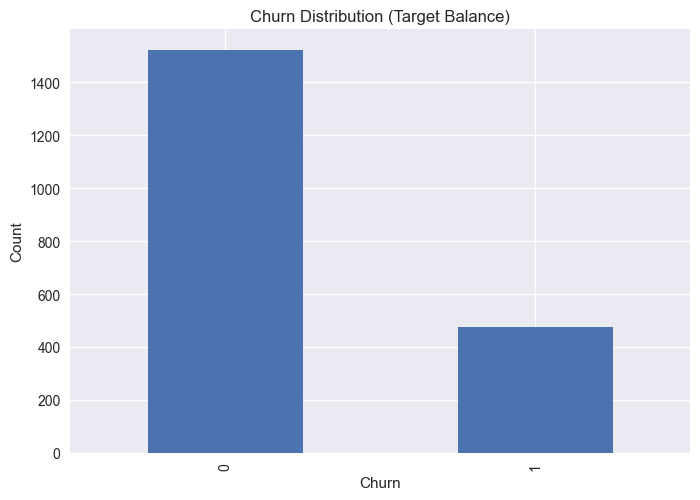

In [9]:
# Visualize imbalance
print(df['churn'].value_counts())
df['churn'].value_counts().plot(kind="bar")
plt.title("Churn Distribution (Target Balance)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


#### Feature Engineering

In [10]:
df_new = add_features(df)
display(df_new.head(), df_new.shape)


,plan_type,monthly_data_gb,avg_call_minutes,num_support_tickets_last_3m,num_dropped_calls_last_30d,payment_method,auto_pay,last_bill_amount,is_promo,city,region,device_type,contract_type,data_overage_gb_last_3m,intl_call_minutes_last_3m,complaints_last_3m,net_promoter_score,age,gender,churn,tenure_days,days_since_last_activity,is_new_customer,tickets_per_dropped
0,Standard,8.282826,291.162602,0,2,credit_card,0,95.514717,1,Cairo,Alex,iOS,one-year,1.753662,50.494030,0,8.0,24,M,0,345,40,0,0.000000
1,Basic,12.028792,NaN,0,0,wallet,0,97.148673,0,Ismailia,UpperEgypt,Android,one-year,0.000000,27.638448,1,4.0,66,F,0,773,76,0,0.000000
2,Premium,11.019622,259.389260,1,1,cash,1,109.951897,0,Giza,UpperEgypt,iOS,one-year,0.613246,0.000000,0,-9.0,51,F,0,237,30,0,0.500000
3,Basic,13.410801,91.825116,1,2,wallet,1,88.091393,0,Cairo,Alex,Android,month-to-month,0.000000,0.153579,1,9.0,39,F,1,443,58,0,0.333333
4,Standard,20.296799,352.166485,2,1,wallet,1,144.459742,0,Giza,Alex,iOS,one-year,0.000000,53.295349,0,2.0,66,M,1,1213,107,0,1.000000


(2000, 24)

#### Train-Test Split

In [11]:
X = df_new.drop(columns=["churn"])
y = df_new["churn"]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)


In [13]:
# Columns by dtype
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()


#### Data Normalization and Preprocessing
- Min-Max normalization keeps features on a comparable [0, 1] range to stabilize optimization and distance-based methods.
- Models that rely on this normalization: SVM (margin-based), Neural Network/MLP (gradient-based), and K-Means (distance-based clustering).
- Categorical fields are imputed then one-hot encoded; numeric fields are imputed then scaled.

In [14]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])


In [15]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


In [16]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


#### Logistic Regression Baseline
Logistic Regression is treated here as a probabilistic linear classifier that scores samples with a linear combination of features and passes the result through a sigmoid activation function to output churn probabilities.

#### Decision Trees, Information Gain, and Random Forests
- Entropy measures node impurity; lower entropy means purer class mixes.
- Information Gain is the entropy reduction obtained after a split.
- Recursive partitioning grows the tree by repeatedly choosing splits with the best Information Gain until stopping rules are met.
- Deep trees can overfit noisy patterns; pruning depth or minimum samples controls variance.
- Random Forests are ensembles of multiple decision trees trained using bagging and feature randomness to reduce variance and improve generalization.

#### Support Vector Machine Intuition
- Feature space: input vectors are viewed geometrically, possibly after implicit mapping.
- Hyperplane: the decision boundary separating churn vs. non-churn classes.
- Margin maximization: the optimal hyperplane maximizes the distance to the closest points from each class.
- Support vectors are the training points that lie on the margin and determine the boundary.

#### Neural Network (MLP) Notes
- A perceptron is a linear unit with a weighted sum and activation.
- Hidden layers stack perceptrons to learn useful intermediate representations.
- Non-linear activation (ReLU here) allows the network to learn non-linear decision boundaries beyond what linear models capture.

#### K-Means Clustering for Segmentation
- Supervised learning uses labeled churn outcomes; unsupervised learning like K-Means groups customers without using labels.
- Customer segmentation discovers clusters with similar behavior so retention policies can target each group differently.
- Min-Max normalized features keep distances meaningful when assigning customers to centroids.

#### Models Preparation

In [17]:
models = {
    "log_reg_baseline": LogisticRegression(max_iter=800, class_weight="balanced", n_jobs=-1, solver="lbfgs"),
    "decision_tree": DecisionTreeClassifier(
        max_depth=8, min_samples_leaf=10, class_weight="balanced", random_state=RANDOM_STATE
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=350, random_state=RANDOM_STATE, class_weight="balanced_subsample"
    ),
    "knn": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "svm_rbf": SVC(
        probability=True,
        kernel="rbf",
        class_weight="balanced",
        C=1.5,
        gamma="scale",
        random_state=RANDOM_STATE,
    ),
    "mlp": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate="adaptive",
        max_iter=400,
        early_stopping=True,
        random_state=RANDOM_STATE,
    ),
}

display_name_map = {
    "log_reg_baseline": "Logistic Regression (Baseline)",
    "decision_tree": "Decision Tree Classifier",
    "random_forest": "Random Forest Classifier",
    "knn": "K-Nearest Neighbors (KNN)",
    "svm_rbf": "Support Vector Machine (RBF Kernel)",
    "mlp": "Neural Network (Multilayer Perceptron)",
}


#### Train, Evaluate, and Compare Supervised Models
Accuracy, Precision, Recall, F1, and ROC-AUC are computed on the held-out test set; ROC-AUC is used for model selection.

c:\Users\ammar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ammar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ammar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ammar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n

log_reg_baseline 5-fold CV Balanced Accuracy: 0.698 +/- 0.021
              precision    recall  f1-score   support

           0      0.865     0.711     0.781       305
           1      0.409     0.642     0.500        95

    accuracy                          0.695       400
   macro avg      0.637     0.677     0.640       400
weighted avg      0.756     0.695     0.714       400



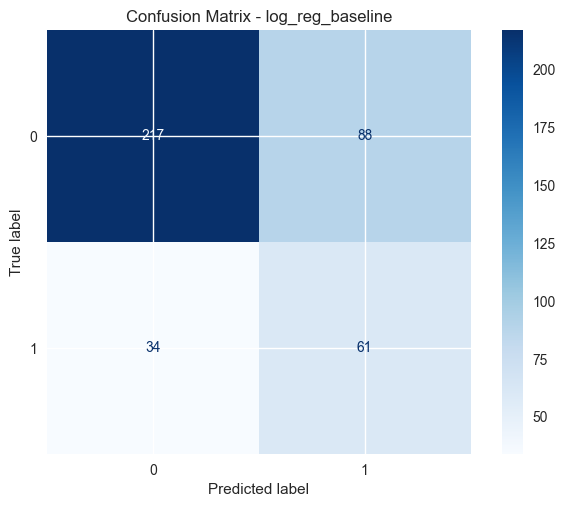

decision_tree 5-fold CV Balanced Accuracy: 0.595 +/- 0.035
              precision    recall  f1-score   support

           0      0.764     0.584     0.662       305
           1      0.240     0.421     0.305        95

    accuracy                          0.545       400
   macro avg      0.502     0.502     0.484       400
weighted avg      0.639     0.545     0.577       400



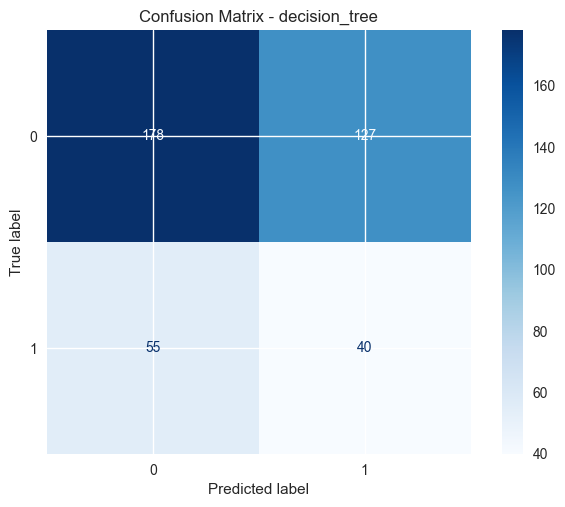

random_forest 5-fold CV Balanced Accuracy: 0.520 +/- 0.008
              precision    recall  f1-score   support

           0      0.773     0.984     0.866       305
           1      0.583     0.074     0.131        95

    accuracy                          0.767       400
   macro avg      0.678     0.529     0.498       400
weighted avg      0.728     0.767     0.691       400



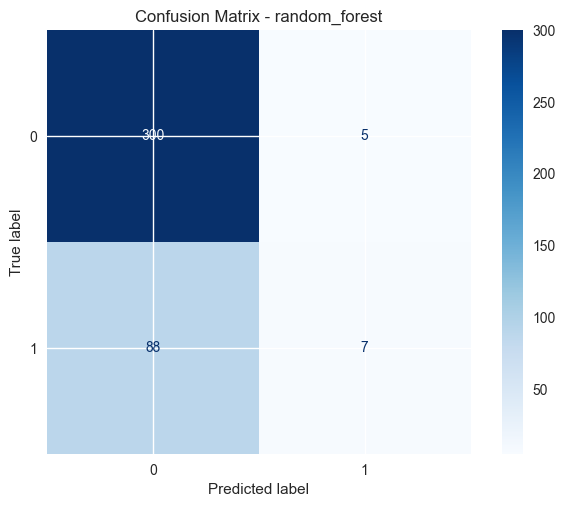

knn 5-fold CV Balanced Accuracy: 0.526 +/- 0.018
              precision    recall  f1-score   support

           0      0.770     0.934     0.844       305
           1      0.333     0.105     0.160        95

    accuracy                          0.738       400
   macro avg      0.552     0.520     0.502       400
weighted avg      0.666     0.738     0.682       400



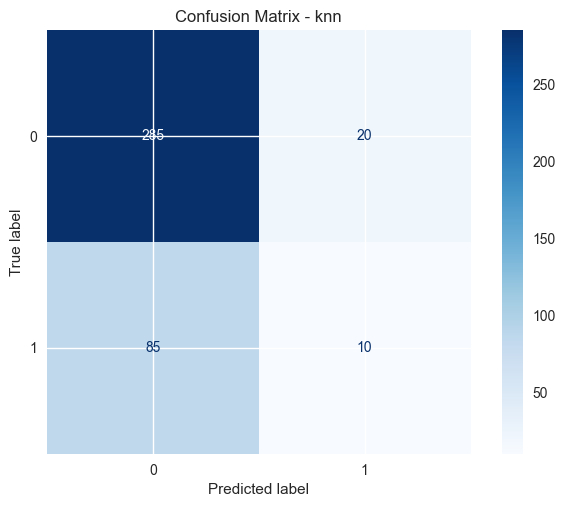

svm_rbf 5-fold CV Balanced Accuracy: 0.640 +/- 0.031
              precision    recall  f1-score   support

           0      0.837     0.705     0.765       305
           1      0.371     0.558     0.445        95

    accuracy                          0.670       400
   macro avg      0.604     0.631     0.605       400
weighted avg      0.726     0.670     0.689       400



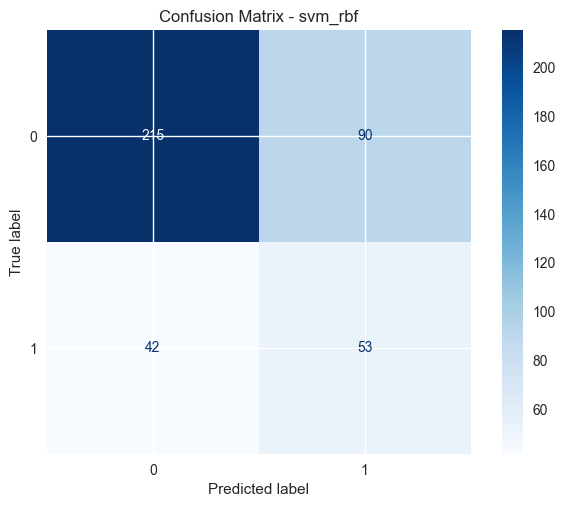

mlp 5-fold CV Balanced Accuracy: 0.533 +/- 0.022
              precision    recall  f1-score   support

           0      0.817     0.934     0.872       305
           1      0.608     0.326     0.425        95

    accuracy                          0.790       400
   macro avg      0.712     0.630     0.648       400
weighted avg      0.767     0.790     0.765       400



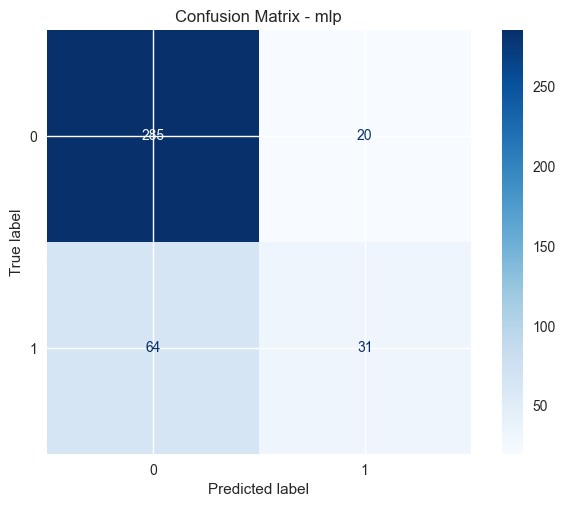

,accuracy,precision,recall,f1,roc_auc
model,,,,,
log_reg_baseline,0.6950,0.409396,0.642105,0.500000,0.735013
mlp,0.7900,0.607843,0.326316,0.424658,0.705781
random_forest,0.7675,0.583333,0.073684,0.130841,0.689819
svm_rbf,0.6700,0.370629,0.557895,0.445378,0.685384
knn,0.7375,0.333333,0.105263,0.160000,0.577912
decision_tree,0.5450,0.239521,0.421053,0.305344,0.567144


In [18]:
metrics_records = []
pipelines = {}

for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    display_name = display_name_map.get(name, name)
    # 5-fold CV Balanced Accuracy
    bal_acc = cross_val_score(clf, X_train, y_train, cv=5, scoring="balanced_accuracy")
    print(f"{display_name} 5-fold CV Balanced Accuracy: {bal_acc.mean():.3f} +/- {bal_acc.std():.3f}")
    # Fit full train
    clf.fit(X_train, y_train)
    pipelines[name] = clf

    # Held-out test predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    metrics_records.append({
        "model_key": name,
        "model": display_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
    })

    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix - {display_name}")
    plt.show()

metrics_df = pd.DataFrame(metrics_records).set_index("model").sort_values("roc_auc", ascending=False)
display(metrics_df)


In [19]:
# Logistic Regression churn probabilities (sample)
log_reg_probs = pipelines["log_reg_baseline"].predict_proba(X_test)[:, 1]
prob_sample = pd.DataFrame({
    "true_churn": y_test.reset_index(drop=True),
    "log_reg_probability": log_reg_probs
})
display(prob_sample.head(10))


,true_churn,log_reg_probability
0,0,0.616154
1,0,0.775658
2,0,0.474053
3,0,0.282943
4,1,0.671821
5,0,0.312055
6,0,0.215830
7,0,0.129157
8,0,0.353451
9,0,0.182518


#### Model Evaluation & Selection

In [20]:
sorted_metrics = metrics_df.sort_values("roc_auc", ascending=False)
best_model_display = sorted_metrics.index[0]
best_model_key = sorted_metrics["model_key"].iloc[0]
best_auc = sorted_metrics.iloc[0]["roc_auc"]
print(f"Best model by ROC-AUC: {best_model_display} ({best_auc:.3f})")

best_model = pipelines[best_model_key]


Best model by ROC-AUC: log_reg_baseline (0.735)


In [21]:
# K-Means clustering for customer segmentation
kmeans_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("kmeans", KMeans(n_clusters=3, n_init=20, random_state=RANDOM_STATE)),
])

cluster_labels = kmeans_pipeline.fit_predict(X)

cluster_df = df_new.copy()
cluster_df["cluster"] = cluster_labels
cluster_churn = cluster_df.groupby("cluster")["churn"].agg(["count", "mean"])
cluster_churn = cluster_churn.rename(columns={"mean": "churn_rate"})

display(cluster_churn)


,count,churn_rate
cluster,,
0,644,0.206522
1,826,0.262712
2,530,0.239623


In [22]:
# Persist pipelines and evaluation splits for deployment
joblib.dump(pipelines, "all_churn_pipelines.pkl")
X_test.to_csv("X_test_churn.csv", index=False)
y_test.to_csv("y_test_churn.csv", index=False)
